In [1]:
%run lgs03a_data_unification.ipynb

In [2]:
sns.set(style='ticks')

# Effects of single mutations

### Distribution of mutation effects

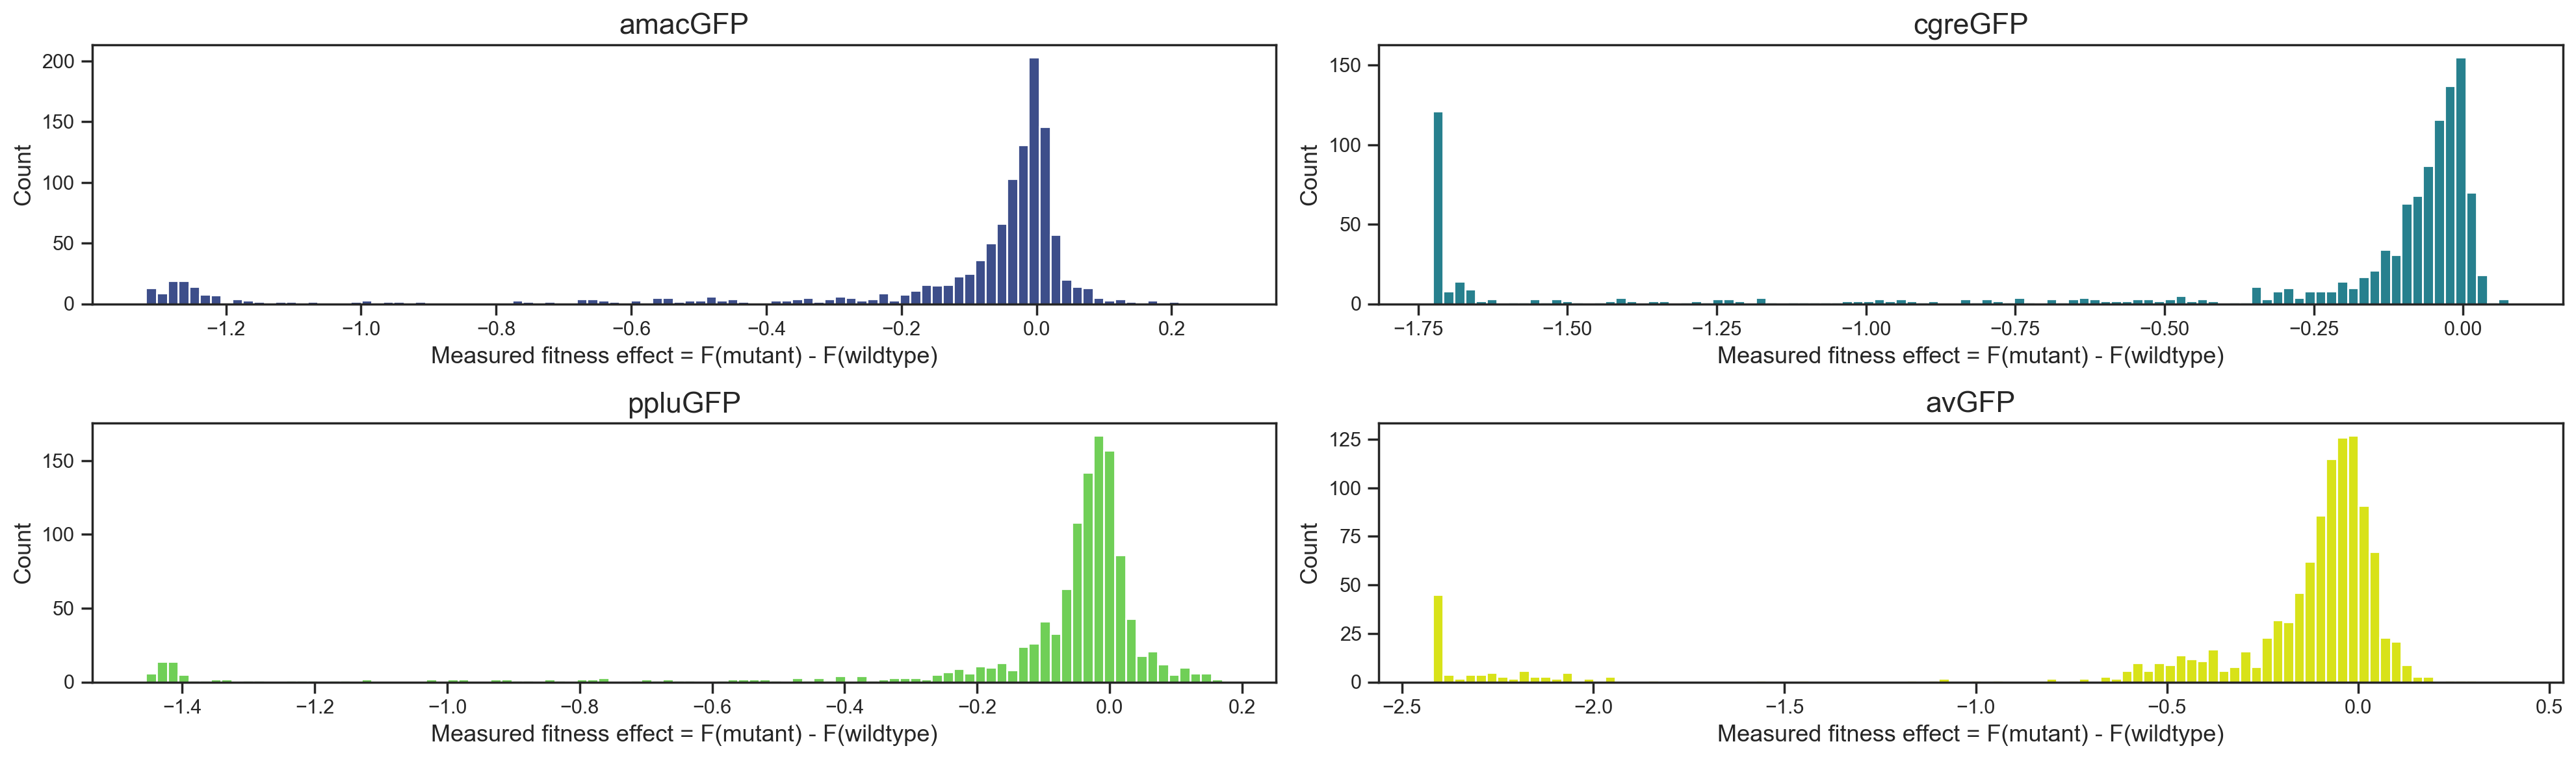

In [3]:
axes = subplots(height=3, width=10, nplots=4, nplots_per_row=2)
for ax,gene in zip(axes, ['amac', 'cgre', 'pplu', 'av']):
    plt.sca(ax)
    plt.hist(data_aa[eval(gene+'_mask') & singles_mask]['measured_effect'], bins=100, color=colors[gene])
    label_plot_axis(t=gene+'GFP', x='Measured fitness effect = F(mutant) - F(wildtype)', y = 'Count')
plt.tight_layout()

### Impact of mutations on buried vs. exposed residues
Buried sites are more sensitive to mutation, in all genes.

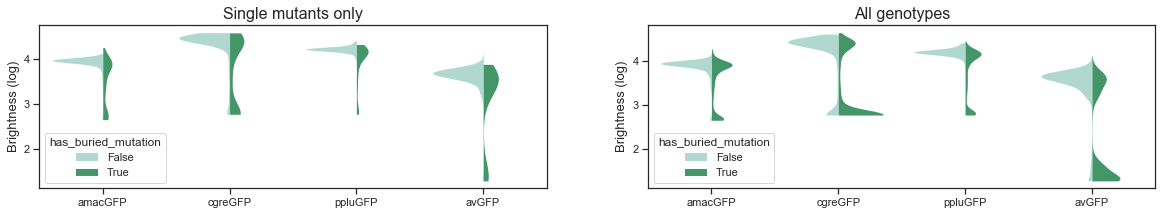

In [4]:
plt.figure(figsize=[20,3])
plt.subplot(1,2,1)
sns.violinplot(data=data_aa[~amacV14L_mask & singles_mask], x='gene', y='brightness', hue='has_buried_mutation', 
               split=True, linewidth=0, palette='BuGn', cut=0)
label_plot_axis(t='Single mutants only', y='Brightness (log)')
plt.subplot(1,2,2)
sns.violinplot(data=data_aa[~amacV14L_mask], x='gene', y='brightness', hue='has_buried_mutation', split=True,
              linewidth=0, palette='BuGn', cut=0)
label_plot_axis(t='All genotypes', y='Brightness (log)')


### Effects of different amino acids

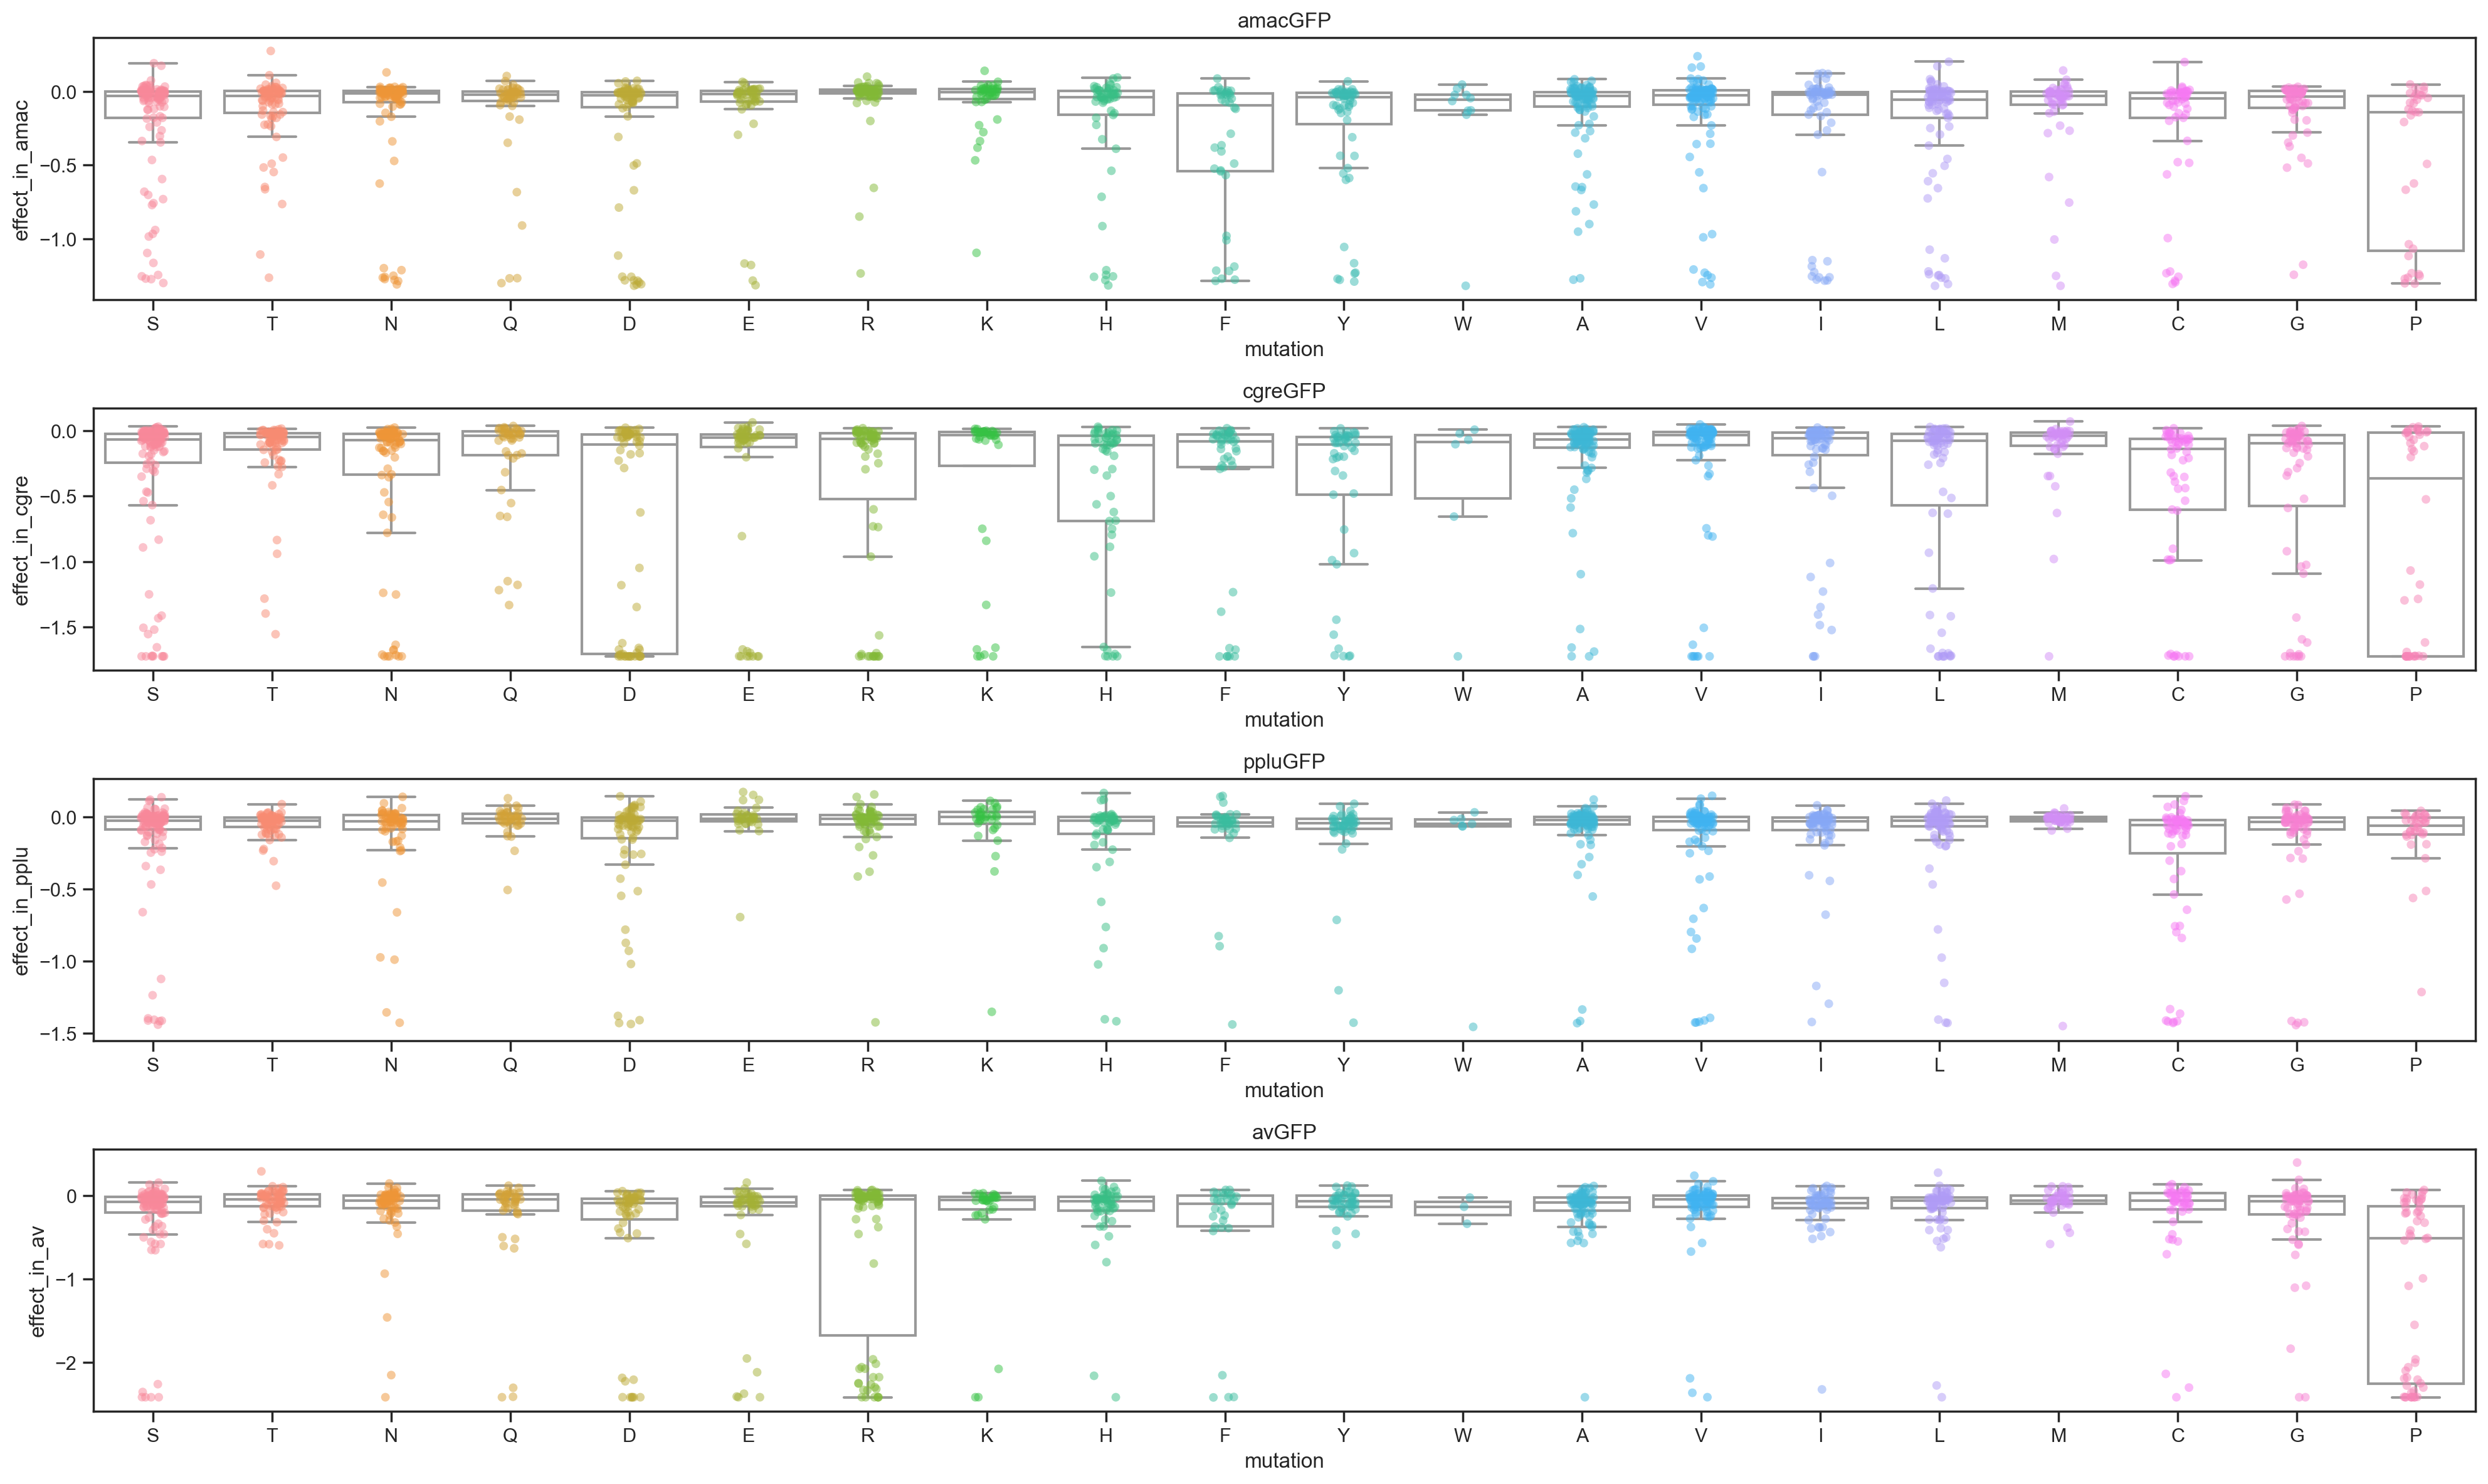

In [5]:
axes = subplots(height=3, width=20, nplots=4, nplots_per_row=1)
for ax,gene in zip(axes, ['amac','cgre','pplu', 'av']):
    plt.sca(ax)
    sns.boxplot(data=df_effects_singles[df_effects_singles['mutation']!='.'], x='mutation', y='effect_in_'+gene,
                color='white', fliersize=0, order='STNQDERKHFYWAVILMCGP')
    sns.stripplot(data=df_effects_singles[df_effects_singles['mutation']!='.'], x='mutation',y='effect_in_'+gene,
                 alpha=0.5, order='STNQDERKHFYWAVILMCGP')
    plt.title(gene+'GFP')
plt.tight_layout()

#### Mutations are slightly worse when the amino acid type is changed

In [6]:
aatype_to_aa = {'aliphatic':'AILMV', 'aromatic':'HFWY', 'positive_charge':'RHK', 'negative_charge':'DE',
                   'polar_uncharged':'STNQ', 'other':'CGP'}
aa_to_aatype = {aa : aatype for aatype in aatype_to_aa for aa in aatype_to_aa[aatype]}

amac MannwhitneyuResult(statistic=122638.0, pvalue=0.0016387890363361837)
cgre MannwhitneyuResult(statistic=90098.5, pvalue=1.0455078674812603e-14)
pplu MannwhitneyuResult(statistic=104501.0, pvalue=9.981719076990777e-06)
av MannwhitneyuResult(statistic=78801.0, pvalue=2.664119279359509e-10)


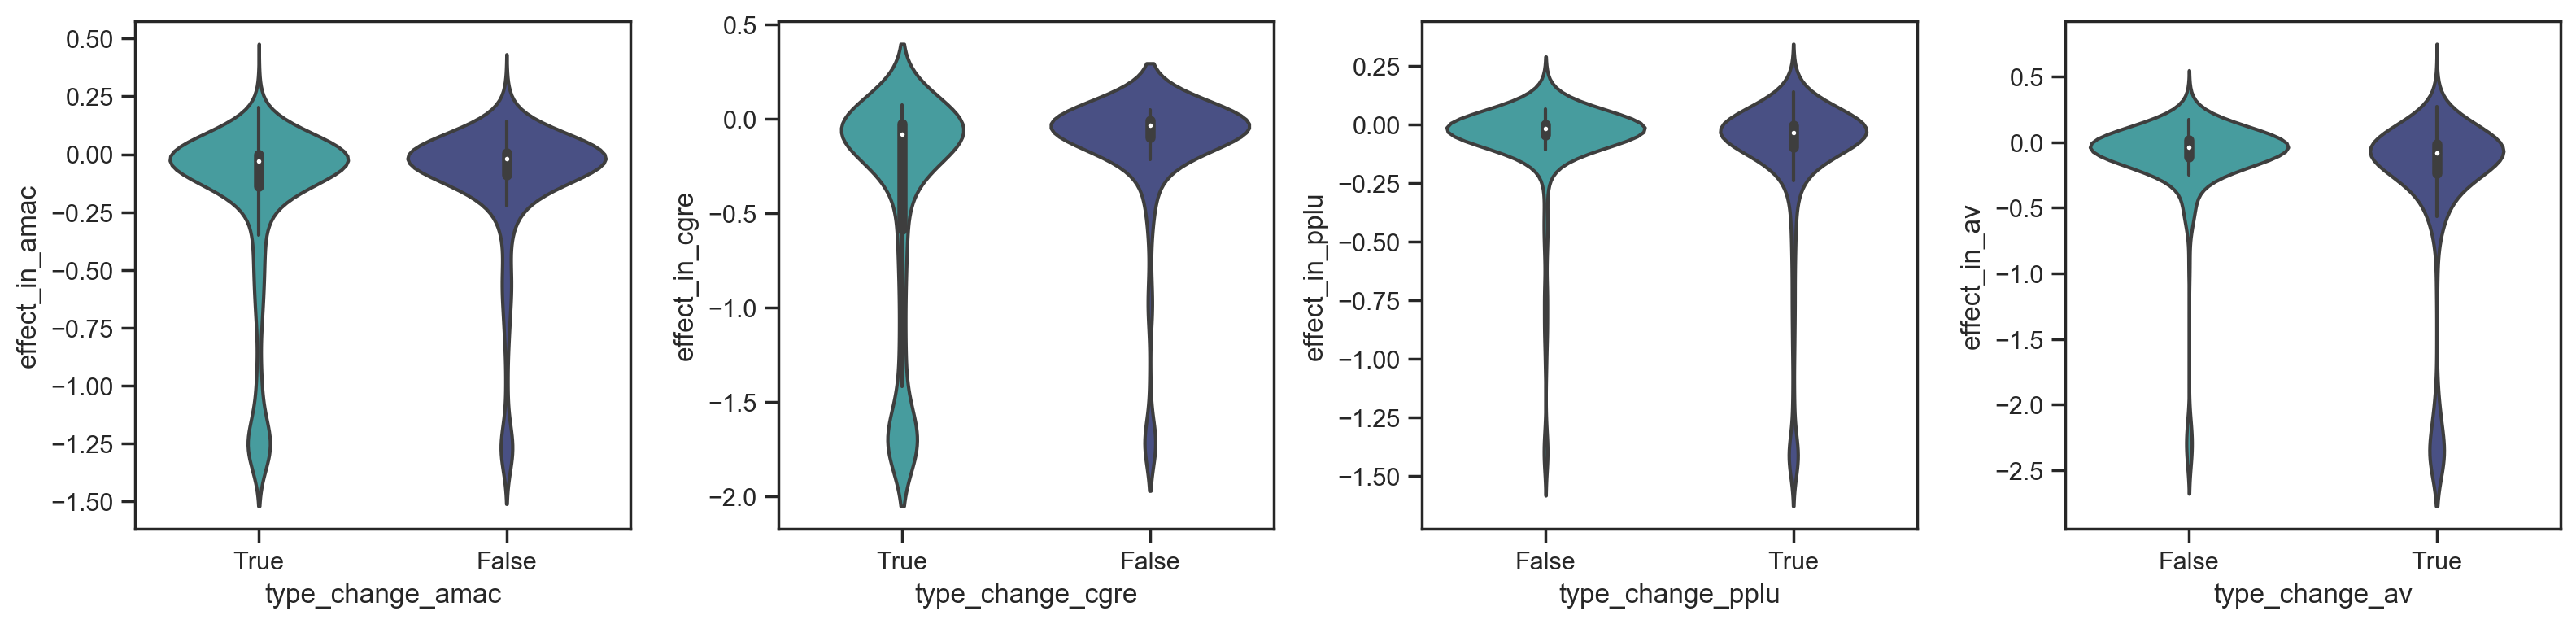

In [7]:
df = df_effects_singles.copy()

axes = subplots(nplots=4, nplots_per_row=4)
for ax, gene in zip(axes, ['amac', 'cgre', 'pplu', 'av']):
    df['type_change_'+gene] = df[['wt_state_'+gene, 'mutation']].apply(lambda x: 
                                            np.nan if x[1] in '*.' or x[0] in '*-' else
                                         True if aa_to_aatype[x[0]]!=aa_to_aatype[x[1]] else False, axis=1)
    a = df[df['type_change_'+gene]==True]['effect_in_'+gene].dropna()
    b = df[df['type_change_'+gene]==False]['effect_in_'+gene].dropna()
    print(gene, scipy.stats.mannwhitneyu(a,b))
    
    plt.sca(ax)
    sns.violinplot(data=df[df['effect_in_'+gene].notnull()], y='effect_in_'+gene, 
                   x='type_change_'+gene, palette='mako_r')
plt.tight_layout()

# Distribution of fitnesses by number of mutations

In [8]:
def get_fitnesses_by_nmut(gene, n):
    wt = data_nt[eval(gene+'_mask_nt') & wt_mask_nt]['log_brightness']
    muts = [data_aa[eval(gene+'_mask') & (data_aa['n_mut']==i)]['brightness'] for i in range(1,n)]
    labels = ['WT\nn = %s' % str(len(wt))]
    labels.extend(['%s mutations,\nn = %s' % (i, len(muts[i-1])) for i in range(1,n)])

    plt.violinplot([list(wt)]+[list(x) for x in muts], showmedians=True, showmeans=False)
    label_plot_axis(t=gene+'GFP', y='Brightness (log)')
    plt.xticks(range(1,n+1), labels)

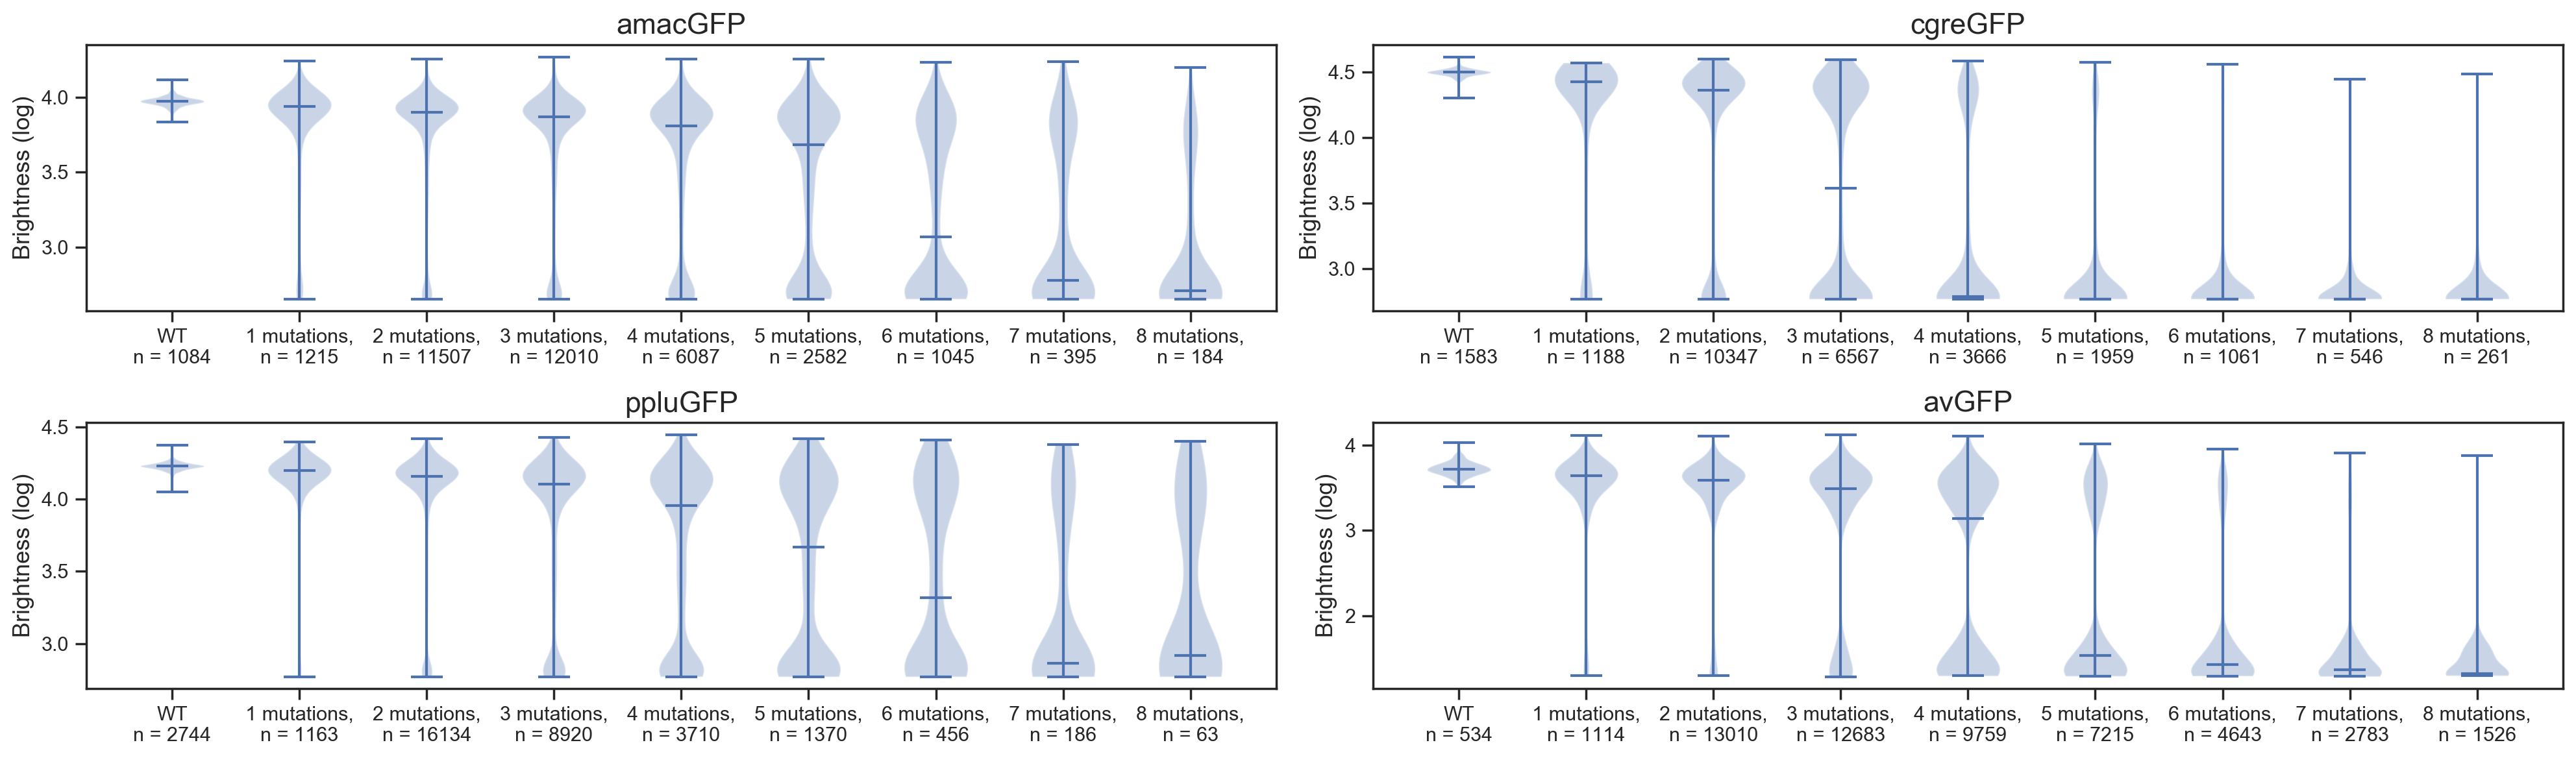

In [9]:
axes = subplots(height=3, width=10, nplots=4, nplots_per_row=2)
for ax,gene in zip(axes, ['amac', 'cgre', 'pplu', 'av']):
    plt.sca(ax)
    get_fitnesses_by_nmut(gene, 9)
plt.tight_layout()

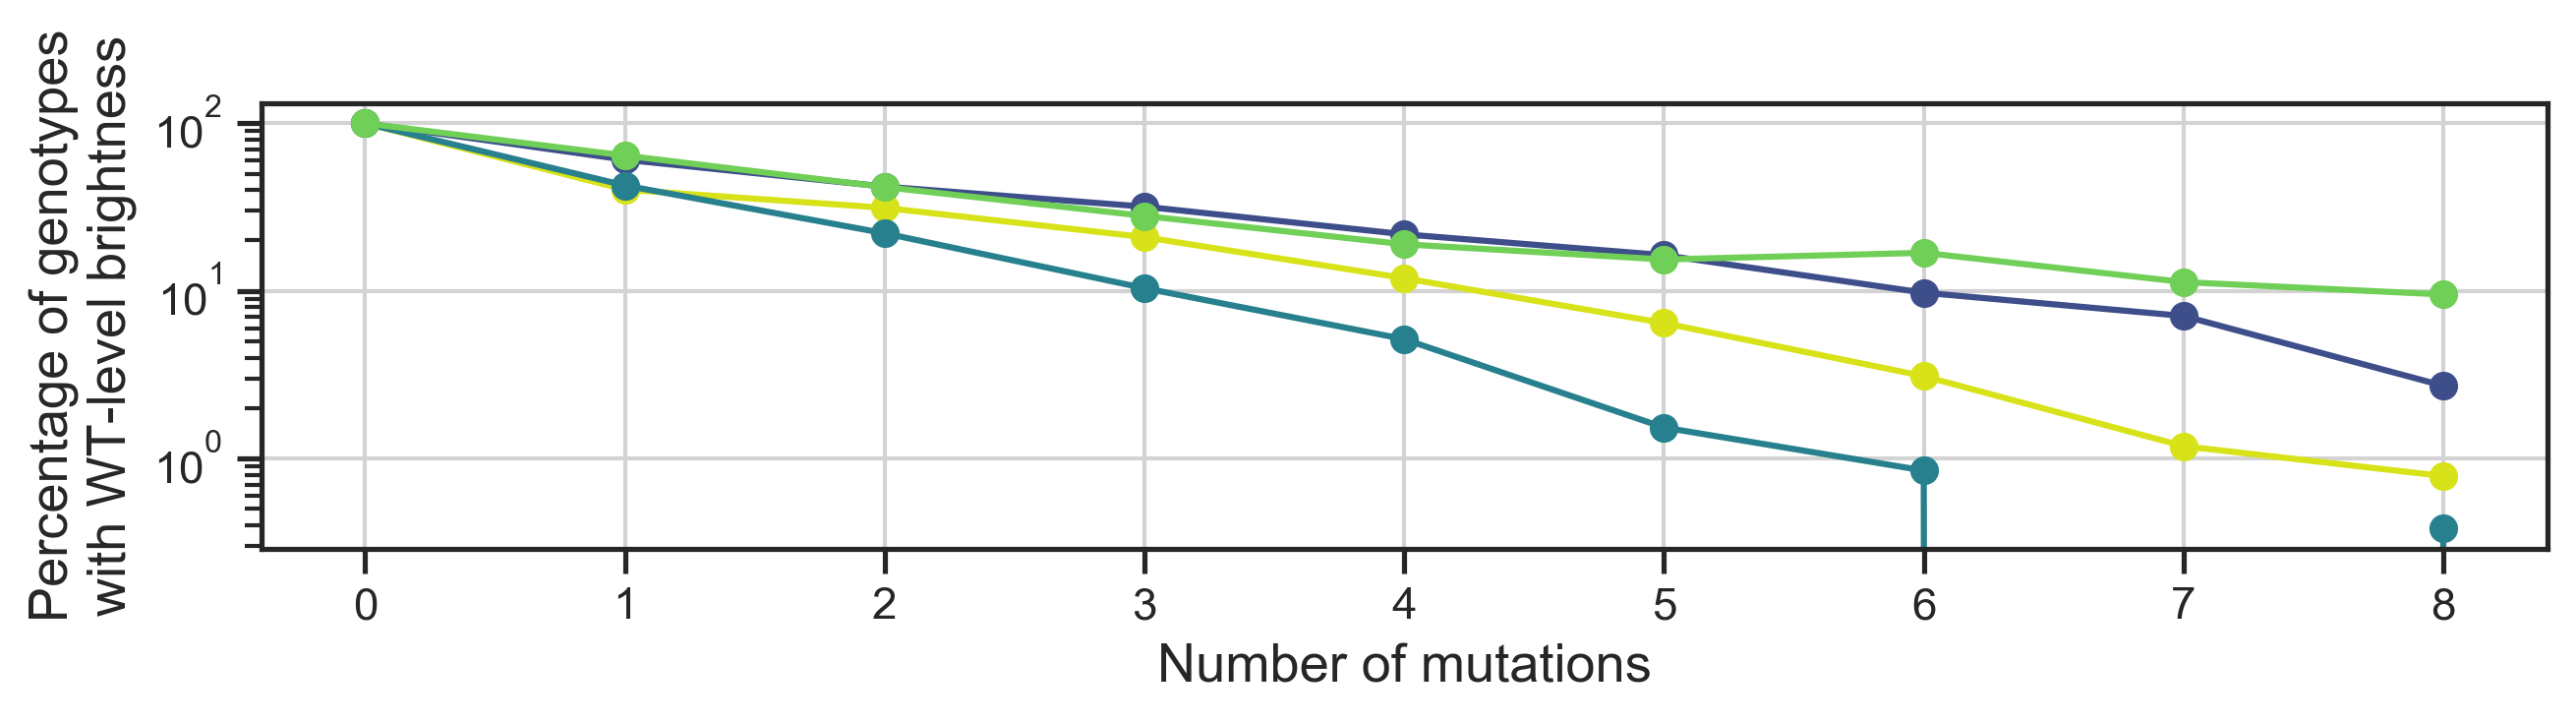

In [23]:
neutral_threshold = 0.05

plt.figure(figsize=[10,2], dpi=200)
for gene in ['amac', 'av', 'cgre', 'pplu']:
    total = np.array([len(data_aa[eval(gene+'_mask') & (data_aa.n_mut==i)]) for i in range(9)])
    wt_bright = np.array([len(data_aa[eval(gene+'_mask') & (data_aa.n_mut==i) 
                    & (data_aa.brightness >= ref_wt_log[gene+'GFP']-neutral_threshold)]) for i in range(9)])
    plt.plot(100*(wt_bright/total), color=colors[gene], marker='o')
    plt.yscale('log')
    plt.grid(color='lightgrey')
    label_plot_axis(y='Percentage of genotypes\nwith WT-level brightness', x='Number of mutations')

In [10]:
def cheesescapes(n=9, col='brightness', cmap='viridis'):
    cm = plt.get_cmap(cmap)
    
    medians = {}
    for i in range(n):
        n_mask = data_aa_scaled['n_mut']==i
        medians[i] = [data_aa_scaled[amac_mask & n_mask][col].median() * 255, 
                      data_aa_scaled[cgre_mask & n_mask][col].median() * 255,
                      data_aa_scaled[pplu_mask & n_mask][col].median() * 255,
                      data_aa_scaled[av_mask & n_mask][col].median() * 255]
    x = 2
    for i in range(n)[::-1]:
        if i==n-1:
            labels = ['amacGFP','cgreGFP','ppluGFP2','avGFP']
        else:
            labels = ['','','','']
        c = cm([int(j) for j in medians[i]])
        plt.pie([1,1,1,1], radius=(x+i)/10, colors=c, labels=labels, wedgeprops={'linewidth':0.5,'edgecolor':'w'},
               startangle=-45, )
        
        c2 = cm(int(255 - medians[i][0]))
        plt.text((x+i)/10 - 0.05, 0, i,
                horizontalalignment='center', verticalalignment='center', color=c2, weight='semibold')

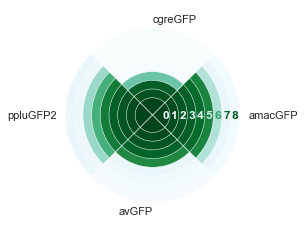

In [11]:
cheesescapes(cmap='BuGn')